In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np  
import pandas as pd  
from matplotlib import pyplot as plt 
import torch 
import torch.nn as nn
import tensorflow as tf
import time


train_data_path ='/content/drive/My Drive/train.csv'
train = pd.read_csv(train_data_path)

num_of_train_data = train.shape[0]

test_data_path ='/content/drive/My Drive/test.csv'
test = pd.read_csv(test_data_path)

num_of_test_data = test.shape[0]

target = train["Capacity(State of Charge)"] # capacity
train.drop(["Capacity(State of Charge)"],axis = 1 , inplace = True) # drop target column

# combine train and test
val = test["Capacity(State of Charge)"] # capacity
test.drop(["Capacity(State of Charge)"],axis = 1 , inplace = True) # drop target column
combined = train.append(test)
combined.reset_index(inplace=True)
combined.drop(['index'], inplace=True, axis=1)

# train dataset features
train_features = torch.tensor(combined[:num_of_train_data].values, dtype=torch.float)
# target
train_labels = torch.tensor(target.values, dtype=torch.float).view(-1, 1)

#val_features = torch.tensor(combined[num_of_train_data:num_of_train_data+25].values, dtype=torch.float)
#val_labels = torch.tensor(val[0:25].values, dtype=torch.float).view(-1, 1)


test_features = torch.tensor(combined[num_of_train_data:].values, dtype=torch.float)
test_true_value = torch.tensor(val.values, dtype=torch.float).view(-1, 1)


print("train data size: ", train_features.shape)
print("train label data size: ", train_labels.shape)
#print("valid data size: ", val_features.shape)
#print("valid label data size: ", val_labels.shape)
print("test data size: ", test_features.shape)
print("test label data size: ", test_true_value.shape)

train data size:  torch.Size([118, 6])
train label data size:  torch.Size([118, 1])
test data size:  torch.Size([50, 6])
test label data size:  torch.Size([50, 1])


In [3]:
model_sequential = nn.Sequential(
          nn.Linear(train_features.shape[1], 128),
          nn.ReLU(),
          nn.Linear(128, 256),
          nn.ReLU(),
          nn.Linear(256, 256),
          nn.ReLU(),
          nn.Linear(256, 256),
          nn.ReLU(),
          nn.Linear(256, 1)
        )

class Net(nn.Module):
  
    def __init__(self, features):
        super(Net, self).__init__()
        
        self.linear_relu1 = nn.Linear(features, 128)
        self.linear_relu2 = nn.Linear(128, 256)
        self.linear_relu3 = nn.Linear(256, 256)
        self.linear_relu4 = nn.Linear(256, 256)
        self.linear5 = nn.Linear(256, 1)
        
    def forward(self, x):
        
        y_pred = self.linear_relu1(x)
        y_pred = nn.functional.relu(y_pred)

        y_pred = self.linear_relu2(y_pred)
        y_pred = nn.functional.relu(y_pred)

        y_pred = self.linear_relu3(y_pred)
        y_pred = nn.functional.relu(y_pred)

        y_pred = self.linear_relu4(y_pred)
        y_pred = nn.functional.relu(y_pred)

        y_pred = self.linear5(y_pred)
        return y_pred

model = Net(features=train_features.shape[1])

# loss function
criterion = nn.MSELoss(reduction='mean')

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [4]:
# train model
epoch = 1000
train_losses = []
val_losses = []
s_time = time.time()
for t in range(epoch):
    model.train()
    y_pred = model(train_features)
    
    tr_loss = criterion(y_pred, train_labels)
    train_losses.append(tr_loss.item())
    
    if torch.isnan(tr_loss):
        break
    
    optimizer.zero_grad()
    
    # backward
    tr_loss.backward()
    optimizer.step()
    
    """
    model.eval()
    with torch.no_grad():
        val_pred = model(val_features)
        val_loss = criterion(val_pred, val_labels)
        # print(t, loss.item())
        val_losses.append(val_loss.item())
    """

    if t % 100 == 0:  
        print(f"Epoch: {t}, Train loss :{tr_loss:.3f}") #, Val loss :{val_loss:.3f}
c_time = time.time()
ss_time = c_time - s_time 
print('%.3f秒'%ss_time)

Epoch: 0, Train loss :2.556
Epoch: 100, Train loss :0.049
Epoch: 200, Train loss :0.021
Epoch: 300, Train loss :0.014
Epoch: 400, Train loss :0.010
Epoch: 500, Train loss :0.005
Epoch: 600, Train loss :0.002
Epoch: 700, Train loss :0.001
Epoch: 800, Train loss :0.000
Epoch: 900, Train loss :0.000
4.439秒


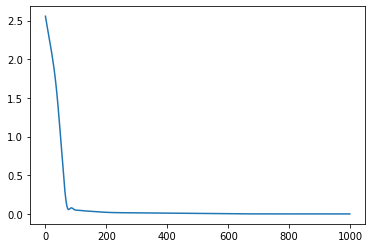

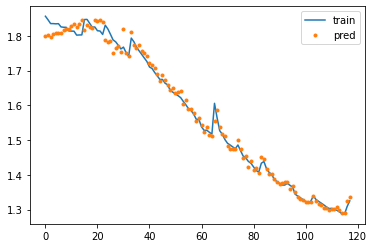

In [7]:
plt.plot(np.arange(1000), train_losses)  
#plt.plot(np.arange(1000), val_losses)
plt.show()  

plt.plot(np.arange(num_of_train_data), train_labels,"-",label = 'train') 
plt.plot(np.arange(num_of_train_data), y_pred.detach().numpy(),".",label = 'pred')  
plt.legend() 

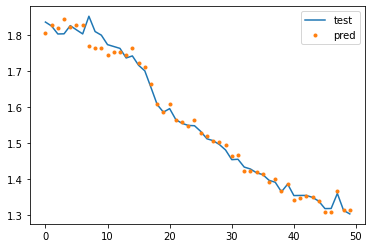

In [9]:
predictions = model(test_features).detach().numpy()
plt.plot(np.arange(num_of_test_data), test_true_value,"-",label = 'test')  
plt.plot(np.arange(num_of_test_data), predictions,".",label = 'pred') 
plt.legend()